In [1]:
# Instalación de paquetes
!pip cache purge
!pip install transformers datasets sentencepiece spacy unidecode pymupdf

# Importación de librerías
import fitz  # pymupdf
import re
import spacy
import torch
from datasets import Dataset
from unidecode import unidecode
import os
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'  # Establece la versión legacy
os.environ["WANDB_DISABLED"] = "true"
#

Files removed: 0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is

In [2]:
# Descargar documento de prueba
!wget  'https://drive.google.com/uc?export=download&id=1JMHAPIZPFBnAZwOqV-lJ2T6-OHZoUlun' -O 'pdf11.pdf'  #10.FAQ_SARLAFT.pdf

# Inicializar variables y cálculo de tamaño
total_bytes = 0
nbytes = 0
for i in range(11, 12):  # antes de 1 a 18
    pdf_filename = f"pdf{i:02d}.pdf"
    nbytes = os.stat(pdf_filename).st_size
    total_bytes += nbytes
megabytes = total_bytes / 1048576
print(f"Total megabytes de todos los documentos cargados: {megabytes}")

--2024-12-24 01:05:19--  https://drive.google.com/uc?export=download&id=1JMHAPIZPFBnAZwOqV-lJ2T6-OHZoUlun
Resolving drive.google.com (drive.google.com)... 173.194.216.138, 173.194.216.113, 173.194.216.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.216.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1JMHAPIZPFBnAZwOqV-lJ2T6-OHZoUlun&export=download [following]
--2024-12-24 01:05:19--  https://drive.usercontent.google.com/download?id=1JMHAPIZPFBnAZwOqV-lJ2T6-OHZoUlun&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.139.132, 2607:f8b0:400c:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.139.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3005487 (2.9M) [application/octet-stream]
Saving to: ‘pdf11.pdf’

pdf11.pdf           100%[===================>]   2.87M  --.-KB/s 

In [3]:
# PRE-PROCESAMIENTO
pat = re.compile(r"[^\w\s%]")
spaces = re.compile(r"\s{2,}")
def preprocess_2(text):
    text = text.replace("Internal", "")
    text = unidecode(text).lower()
    urls = re.findall(r'https?://\S+|www\.\S+', text)
    for i, url in enumerate(urls):
        text = text.replace(url, f'URL{i}')
    text = re.sub(pat, "", text)
    text = re.sub(spaces, " ", text)
    text = text.replace('\n', ' ').replace('\r', ' ')
    for i, url in enumerate(urls):
        text = text.replace(f'URL{i}', url)
    return text

In [4]:
pdf_document = fitz.open(pdf_filename)
doc_text = ""
for page_num in range(len(pdf_document)):
    page = pdf_document.load_page(page_num)
    doc_text += page.get_text("text")

documento_completo = preprocess_2(doc_text)

In [5]:
questions = [
    "¿Cómo se indexa el Formato Único de Conocimiento del Cliente en la ficha de gestión del cliente?",
    "¿Si la póliza fue cancelada o anulada debe tener el Formato Único de Conocimiento del Cliente?",
    "¿Qué pasa si el cliente decidió no renovar la póliza?",
    "¿Qué pasa si la póliza fue emitida pero el cliente desistió del negocio?",
    "¿Qué pasa si después de realizar la gestión definitivamente no se consigue el Formato Único de Conocimiento del Cliente?",
    "¿Las pólizas de entidades estatales requieren SARLAFT?",
    "¿Qué pasa si el cliente cambió de intermediario?",
    "¿Qué pasa cuando el cliente se encuentra en proceso de sucesión ilíquida?",
    "¿Qué documentos se deben indexar a ficha de gestión de cliente para persona natural y persona jurídica?",
    "Una vez se indexa el Formato Único de Conocimiento del Cliente y los documentos soporte el documento de identificación a ficha de gestión de cliente, ¿A dónde se envían los documentos físicos?",
    "¿Qué debe hacer el intermediario si no usa de manera frecuente el correo corporativo @Allia2.com?",
    "¿Dónde se puede visualizar la clave de intermediario?"
]

answers = [
    {"text": "el formato unico de conocimiento del cliente se debe indexar en la ficha de gestion del cliente bajo el codigo 2612 para mayor informacion puede consultar el instructivo anexo o el video que se encuentra en el siguiente link https://vime", "answer_start": 1427},
    {"text": "si por norma todo negocio debe contar con el formato unico de conocimiento del cliente desde el momento de la emision por esta razon es necesario realizar la gestion pertinente para conseguir el documento e indexarlo en la ficha de gestion del cliente bajo el codigo 2612", "answer_start": 1798},
    {"text": "en este caso no es necesario realizar la actualizacion del documento sin embargo es obligatorio que en el sistema se encuentra indexado el formato unico de conocimiento del cliente de la primera vigencia de la poliza", "answer_start": 2122},
    {"text": "de acuerdo con las politicas y procedimientos de america es obligatorio contar con el formato unico de conocimiento del cliente para realizar la emision por esta razon es necesario realizar la gestion pertinente para conseguir el documento e indexarlo en la ficha de gestion del cliente bajo el codigo 2612", "answer_start": 2410},
    {"text": "los formatos que no se indexen en el sistema seguiran registrando como pendientes y continuaran apareciendo en las bases de datos ademas afectaran los indicadores de gestion del intermediario en relacion a este tema", "answer_start": 2836},
    {"text": "las entidades regidas bajo el derecho publico estan exentas del formato unico de conocimiento del cliente", "answer_start": 3105},
    {"text": "en este caso el nuevo intermediario debe hacer la consecucion del formato unico de conocimiento del cliente", "answer_start": 3258},
    {"text": "en estos casos se debe indexar el sarlaft de la persona que quede en cabeza del proceso de sucesion que sera el tomador de la poliza una vez definida la sucesion se debera actualizar el sarlaft con la del dueno final del bien", "answer_start": 3447},
    {"text": "persona natural formato unico de conocimiento del cliente y fotocopia de la cedula de ciudadania ampliada al 150% persona juridica formato unico de conocimiento del cliente copia del rut certificado de existencia y representacion legal emitido por la camara de comercio del domicilio de la compania no mayor a 60 dias en caso de ser entidad financiera tambien debera adjuntar el certificado de la superfinanciera fotocopia del documento de identidad del representante legal que firmo el formulario ampliada al 150% estados financieros auditados de los ultimos 2 anos en caso de tener que ampliar la informacion certificacion firmada por el representante legal o revisor fiscal con la lista de socios o accionistas que tengan una participacion directa o indirecta de mas del 5% del capital social aporte o participacion o constancia de cotizacion en bolsa de valores del cliente o del propietario que tenga mas del 5% de participacion", "answer_start": 4011},
    {"text": "una vez se indexen al sistema los documentos se deben enviar a la sucursal asignada en un sobre sellado en el cual se identifique claramente el remitente nombre del allia2 direccion y telefono y en destinatario incluir a la sucursal asignada posterior a ello la sucursal envia los documentos a back office en casa principal america carrera 13a", "answer_start": 5135},
    {"text": "para no perderse de todos los comunicados que america envia a sus allia2 el agente o agencia pueden comunicarse directamente a la linea telefonica 5188990 centro de atencion al usuario cau y solicitar redireccion automatica a un correo electronico de su preferencia", "answer_start": 5595},
    {"text": "en allia2net plus en la parte superior de la pantalla se puede visualizar el numero de la clave en el campo mediador principal en el librillo de las polizas en la segunda hoja se relacionan las condiciones particulares y se identifica el numero de clave de intermediario ", "answer_start": 5913},
]
# Verificar las posiciones de las respuestas
for i, answer in enumerate(answers):
    start_position = answer["answer_start"] - 1  # Restar 1 a la posición de inicio
    end_position = start_position + len(answer["text"])  # Ajuste para longitud de caracteres
    context = documento_completo[start_position:end_position]
    print(f"Pregunta {i+1}: {questions[i]}")
    print(f"Respuesta: {answer['text']}")
    print(f"Contexto: {context}")
    print("-" * 50)

# Inicializar el diccionario
data_dict_train = {"context": [], "question": [], "answers": []}

# Asociar todas las preguntas con el mismo contexto
for i in range(12):
    data_dict_train["context"].append(documento_completo)
    data_dict_train["question"].append(questions[i % len(questions)])
    data_dict_train["answers"].append(answers[i % len(answers)])

# Crear el dataset
dataset_train = Dataset.from_dict(data_dict_train)

# Verificar la estructura del dataset
print(dataset_train)
#
questions = [
    "¿qué significan las siglas SARLAFT?",
    "¿Por qué es importante el SARLAFT?",
    "¿Qué pasa si el cliente no tiene el SARLAFT en la ficha de gestión?",
    "¿Qué pólizas no requieren SARLAFT?",
]

answers = [
    {"text": "sistema de administración del riesgo de lavado de activos y de la financiación del terrorismo", "answer_start": 85},
    {"text": "La implementación y funcionamiento del sistema de administración del riesgo de lavado de activos y financiación del terrorismo (SARLAFT) permite a las entidades vigiladas prevenir el riesgo de ser utilizadas en operaciones con activos provenientes de actividades relacionadas con del lavado de activos y/o financiación del terrorismo", "answer_start": 212},
    {"text": "de acuerdo con lo establecido en el manual sarlaft es obligatorio que todos los clientes que tengan o hayan tenido una poliza con america seguros sa o america seguros de vida sa tengan indexado el formato unico de conocimiento del cliente en la ficha de gestion para el caso de las polizas vigentes no contar con este documento puede generar la cancelacion inmediata de las polizas que tenga el cliente no aplica para las polizas que no requieren este documento", "answer_start": 609},
    {"text": "de acuerdo con la norma las polizas de soat salud accidentes personales en vuelo los tomados por entidades financieras y las demas que se establecen en el manual sarlaft no requieren el formato unico de conocimiento del cliente", "answer_start": 1104},
]
# Verificar las posiciones de las respuestas
for i, answer in enumerate(answers):
    start_position = answer["answer_start"] - 1  # Restar 1 a la posición de inicio
    end_position = start_position + len(answer["text"])  # Ajuste para longitud de caracteres
    context = documento_completo[start_position:end_position]
    print(f"Pregunta {i+1}: {questions[i]}")
    print(f"Respuesta: {answer['text']}")
    print(f"Contexto: {context}")
    print("-" * 50)

# Inicializar el diccionario
data_dict_test = {"context": [], "question": [], "answers": []}

# Asociar todas las preguntas con el mismo contexto
for i in range(4):
    data_dict_test["context"].append(documento_completo)
    data_dict_test["question"].append(questions[i % len(questions)])
    data_dict_test["answers"].append(answers[i % len(answers)])

# Crear el dataset
dataset_test = Dataset.from_dict(data_dict_test)

# Verificar la estructura del dataset
print(dataset_test)
#

Pregunta 1: ¿Cómo se indexa el Formato Único de Conocimiento del Cliente en la ficha de gestión del cliente?
Respuesta: el formato unico de conocimiento del cliente se debe indexar en la ficha de gestion del cliente bajo el codigo 2612 para mayor informacion puede consultar el instructivo anexo o el video que se encuentra en el siguiente link https://vime
Contexto: el formato unico de conocimiento del cliente se debe indexar en la ficha de gestion del cliente bajo el codigo 2612 para mayor informacion puede consultar el instructivo anexo o el video que se encuentra en el siguiente link https://vime
--------------------------------------------------
Pregunta 2: ¿Si la póliza fue cancelada o anulada debe tener el Formato Único de Conocimiento del Cliente?
Respuesta: si por norma todo negocio debe contar con el formato unico de conocimiento del cliente desde el momento de la emision por esta razon es necesario realizar la gestion pertinente para conseguir el documento e indexarlo en la fi

In [6]:
from transformers import AutoTokenizer

#checkpoint = "bert-large-uncased-whole-word-masking-finetuned-squad"
#checkpoint = "dccuchile/bert-base-spanish-wwm-cased"
#checkpoint = "deepset/xlm-roberta-large-squad2"
checkpoint = "deepset/roberta-large-squad2"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess_function(examples):
    questions = examples["question"]
    contexts = examples["context"]

    inputs = tokenizer(
        questions,
        contexts,
        truncation=True,
        max_length=512,
        stride=128,
        padding="max_length",
        return_offsets_mapping=True,
        return_tensors="np"
    )
    offset_mapping = inputs.pop("offset_mapping")

    start_positions = []
    end_positions = []
    for i, answer in enumerate(examples["answers"]):
        start_char = answer["answer_start"]
        end_char = start_char + len(answer["text"])

        # Encuentra el token correspondiente al carácter de inicio y fin
        start_token = 0
        end_token = 0
        for idx, (start, end) in enumerate(offset_mapping[i]):
            if start_char >= start and end_char <= end:
                start_token = idx
                end_token = idx
                break

        start_positions.append(start_token)
        end_positions.append(end_token)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

# Tokenización de los datos
tokenized_data_train = dataset_train.map(preprocess_function, batched=True)
tokenized_data_test = dataset_test.map(preprocess_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

In [7]:
# Evaluación con métricas
from transformers import AutoModelForQuestionAnswering
!pip install evaluate
from evaluate import load
accuracy_metric = load("accuracy")

def compute_metrics(pred):
    start_preds = pred.predictions[0].argmax(axis=1)
    end_preds = pred.predictions[1].argmax(axis=1)

    if isinstance(pred.label_ids, tuple):
        start_labels = pred.label_ids[0]
        end_labels = pred.label_ids[1]
    else:
        start_labels = pred.label_ids[:, 0]
        end_labels = pred.label_ids[:, 1]

    # Cálculo de métricas para posiciones de inicio
    em_score_start = accuracy_score(start_labels, start_preds)
    f1_start = f1_score(start_labels, start_preds, average="weighted")
    precision_start = precision_score(start_labels, start_preds, average="weighted", zero_division=0)
    recall_start = recall_score(start_labels, start_preds, average="weighted", zero_division=0)

    # Cálculo de métricas para posiciones de fin
    em_score_end = accuracy_score(end_labels, end_preds)
    f1_end = f1_score(end_labels, end_preds, average="weighted")
    precision_end = precision_score(end_labels, end_preds, average="weighted", zero_division=0)
    recall_end = recall_score(end_labels, end_preds, average="weighted", zero_division=0)

    # Promedio de las métricas
    em_score = (em_score_start + em_score_end) / 2
    f1 = (f1_start + f1_end) / 2
    precision = (precision_start + precision_end) / 2
    recall = (recall_start + recall_end) / 2

    return {
        "Exact Match": em_score,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    }




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:00


In [8]:
# BUSQUEDA DE HIPERPARAMETROS CON OPTUNA

!pip install optuna
import optuna
from transformers import TrainingArguments, Trainer

# Carga del modelo
model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)

# Definir la función objetivo para la búsqueda de hiperparámetros
def objective(trial):
    # Espacio de búsqueda para los hiperparámetros
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
    num_train_epochs = trial.suggest_int("num_train_epochs", 2, 6)  # Búsqueda entre 2 y 6 épocas
    warmup_steps = trial.suggest_int("warmup_steps", 100, 1000, step=100)  # Pasos de calentamiento entre 100 y 1000
    evaluation_strategy = trial.suggest_categorical("evaluation_strategy", ["no", "steps", "epoch"])  # Estrategias posibles

    # Configuración de los argumentos de entrenamiento
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy=evaluation_strategy,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        warmup_steps=warmup_steps,
        weight_decay=weight_decay,
        logging_dir="./logs",
        logging_steps=10,
        save_steps=1000,
        fp16=True,
        disable_tqdm=True  # Evitar demasiada salida para Optuna
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_data_train,
        eval_dataset=tokenized_data_test,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Entrenar el modelo
    trainer.train()

    # Evaluar el modelo
    eval_results = trainer.evaluate()

    # Retornar eval_loss como métrica objetivo
    return eval_results["eval_loss"]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [9]:
# Crear el estudio de Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)  # Realizar 15 pruebas para encontrar los mejores hiperparámetros

# Imprimir los mejores hiperparámetros
print("Mejores Hiperparámetros:", study.best_params)

[I 2024-12-24 01:06:28,256] A new study created in memory with name: no-name-c8a4e425-20e5-4c8c-8982-92d37e471ef4
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environmen

{'eval_loss': 0.78521728515625, 'eval_Exact Match': 1.0, 'eval_F1 Score': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.104, 'eval_samples_per_second': 38.445, 'eval_steps_per_second': 9.611, 'epoch': 1.0}
{'eval_loss': 0.78521728515625, 'eval_Exact Match': 1.0, 'eval_F1 Score': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.1218, 'eval_samples_per_second': 32.835, 'eval_steps_per_second': 8.209, 'epoch': 2.0}
{'eval_loss': 0.786224365234375, 'eval_Exact Match': 1.0, 'eval_F1 Score': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.1985, 'eval_samples_per_second': 20.155, 'eval_steps_per_second': 5.039, 'epoch': 3.0}
{'eval_loss': 0.77911376953125, 'eval_Exact Match': 1.0, 'eval_F1 Score': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.1993, 'eval_samples_per_second': 20.065, 'eval_steps_per_second': 5.016, 'epoch': 4.0}
{'loss': 1.5826, 'grad_norm': 51.854835510253906, 'learning_rate': 2.906618086570311e-08, 'e

[I 2024-12-24 01:06:49,652] Trial 0 finished with value: 0.7686767578125 and parameters: {'learning_rate': 3.4879417038843734e-06, 'batch_size': 8, 'weight_decay': 4.182309002433846e-05, 'num_train_epochs': 6, 'warmup_steps': 600, 'evaluation_strategy': 'epoch'}. Best is trial 0 with value: 0.7686767578125.
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py

{'eval_loss': 0.7686767578125, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.1445, 'eval_samples_per_second': 27.68, 'eval_steps_per_second': 6.92, 'epoch': 6.0}
{'train_runtime': 19.9891, 'train_samples_per_second': 3.602, 'train_steps_per_second': 0.6, 'train_loss': 1.4999125798543294, 'epoch': 6.0}
{'eval_loss': 0.7686767578125, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.1087, 'eval_samples_per_second': 36.788, 'eval_steps_per_second': 9.197, 'epoch': 6.0}


<ipython-input-8-6928a621b912>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 1.5453, 'grad_norm': 44.24277877807617, 'learning_rate': 8.629867495145345e-07, 'epoch': 5.0}


[I 2024-12-24 01:07:07,736] Trial 1 finished with value: 0.5759124755859375 and parameters: {'learning_rate': 6.903893996116276e-05, 'batch_size': 8, 'weight_decay': 3.3133093209801066e-05, 'num_train_epochs': 5, 'warmup_steps': 400, 'evaluation_strategy': 'no'}. Best is trial 1 with value: 0.5759124755859375.
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args

{'train_runtime': 17.2943, 'train_samples_per_second': 3.469, 'train_steps_per_second': 0.578, 'train_loss': 1.5452587127685546, 'epoch': 5.0}
{'eval_loss': 0.5759124755859375, 'eval_Exact Match': 0.875, 'eval_F1 Score': 0.9285714285714286, 'eval_Precision': 1.0, 'eval_Recall': 0.875, 'eval_runtime': 0.1385, 'eval_samples_per_second': 28.889, 'eval_steps_per_second': 7.222, 'epoch': 5.0}


<ipython-input-8-6928a621b912>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[I 2024-12-24 01:07:26,519] Trial 2 finished with value: 0.5648193359375 and parameters: {'learning_rate': 3.35405657793323e-05, 'batch_size': 32, 'weight_decay': 5.212968937823072e-05, 'num_train_epochs': 6, 'warmup_steps': 900, 'evaluation_strategy': 'steps'}. Best is trial 2 with value: 0.5648193359375.
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

{'train_runtime': 17.9711, 'train_samples_per_second': 4.006, 'train_steps_per_second': 0.334, 'train_loss': 1.1004558404286702, 'epoch': 6.0}
{'eval_loss': 0.5648193359375, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.1446, 'eval_samples_per_second': 27.669, 'eval_steps_per_second': 6.917, 'epoch': 6.0}


<ipython-input-8-6928a621b912>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.5648193359375, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.0945, 'eval_samples_per_second': 42.35, 'eval_steps_per_second': 10.588, 'epoch': 1.0}


[I 2024-12-24 01:07:32,792] Trial 3 finished with value: 0.5648193359375 and parameters: {'learning_rate': 1.4741659400876282e-05, 'batch_size': 32, 'weight_decay': 0.0023406072504631144, 'num_train_epochs': 2, 'warmup_steps': 1000, 'evaluation_strategy': 'epoch'}. Best is trial 2 with value: 0.5648193359375.
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.

{'eval_loss': 0.5648193359375, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.1422, 'eval_samples_per_second': 28.139, 'eval_steps_per_second': 7.035, 'epoch': 2.0}
{'train_runtime': 5.406, 'train_samples_per_second': 4.439, 'train_steps_per_second': 0.37, 'train_loss': 1.1834964752197266, 'epoch': 2.0}
{'eval_loss': 0.5648193359375, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.1128, 'eval_samples_per_second': 35.476, 'eval_steps_per_second': 8.869, 'epoch': 2.0}


<ipython-input-8-6928a621b912>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.5648193359375, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.1, 'eval_samples_per_second': 39.983, 'eval_steps_per_second': 9.996, 'epoch': 1.0}
{'eval_loss': 0.5648193359375, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.0973, 'eval_samples_per_second': 41.097, 'eval_steps_per_second': 10.274, 'epoch': 2.0}
{'eval_loss': 0.5622711181640625, 'eval_Exact Match': 1.0, 'eval_F1 Score': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.2001, 'eval_samples_per_second': 19.985, 'eval_steps_per_second': 4.996, 'epoch': 3.0}
{'eval_loss': 0.596038818359375, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.2008, 'eval_samples_per_second': 19.918, 'eval_steps_per_second': 4.979, 'epoch': 4.0}
{'loss': 1.5723, 'grad_norm': 36.931285858

[I 2024-12-24 01:07:50,062] Trial 4 finished with value: 0.59075927734375 and parameters: {'learning_rate': 5.212672800215356e-06, 'batch_size': 8, 'weight_decay': 0.0002000059994244411, 'num_train_epochs': 5, 'warmup_steps': 200, 'evaluation_strategy': 'epoch'}. Best is trial 2 with value: 0.5648193359375.
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py

{'eval_loss': 0.59075927734375, 'eval_Exact Match': 0.875, 'eval_F1 Score': 0.9285714285714286, 'eval_Precision': 1.0, 'eval_Recall': 0.875, 'eval_runtime': 0.1433, 'eval_samples_per_second': 27.919, 'eval_steps_per_second': 6.98, 'epoch': 5.0}
{'train_runtime': 16.556, 'train_samples_per_second': 3.624, 'train_steps_per_second': 0.604, 'train_loss': 1.5722827911376953, 'epoch': 5.0}
{'eval_loss': 0.59075927734375, 'eval_Exact Match': 0.875, 'eval_F1 Score': 0.9285714285714286, 'eval_Precision': 1.0, 'eval_Recall': 0.875, 'eval_runtime': 0.1051, 'eval_samples_per_second': 38.05, 'eval_steps_per_second': 9.513, 'epoch': 5.0}


<ipython-input-8-6928a621b912>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[I 2024-12-24 01:08:05,711] Trial 5 finished with value: 0.5872955322265625 and parameters: {'learning_rate': 2.3617148987934916e-05, 'batch_size': 32, 'weight_decay': 0.0019448999234714078, 'num_train_epochs': 5, 'warmup_steps': 500, 'evaluation_strategy': 'steps'}. Best is trial 2 with value: 0.5648193359375.
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases

{'train_runtime': 14.8621, 'train_samples_per_second': 4.037, 'train_steps_per_second': 0.336, 'train_loss': 0.9952914237976074, 'epoch': 5.0}
{'eval_loss': 0.5872955322265625, 'eval_Exact Match': 0.875, 'eval_F1 Score': 0.9285714285714286, 'eval_Precision': 1.0, 'eval_Recall': 0.875, 'eval_runtime': 0.1396, 'eval_samples_per_second': 28.645, 'eval_steps_per_second': 7.161, 'epoch': 5.0}


<ipython-input-8-6928a621b912>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[I 2024-12-24 01:08:11,864] Trial 6 finished with value: 0.5872955322265625 and parameters: {'learning_rate': 1.0591608613620595e-06, 'batch_size': 32, 'weight_decay': 2.269475710142146e-05, 'num_train_epochs': 2, 'warmup_steps': 1000, 'evaluation_strategy': 'steps'}. Best is trial 2 with value: 0.5648193359375.
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/release

{'train_runtime': 5.2631, 'train_samples_per_second': 4.56, 'train_steps_per_second': 0.38, 'train_loss': 1.1376558542251587, 'epoch': 2.0}
{'eval_loss': 0.5872955322265625, 'eval_Exact Match': 0.875, 'eval_F1 Score': 0.9285714285714286, 'eval_Precision': 1.0, 'eval_Recall': 0.875, 'eval_runtime': 0.1457, 'eval_samples_per_second': 27.463, 'eval_steps_per_second': 6.866, 'epoch': 2.0}


<ipython-input-8-6928a621b912>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.5872955322265625, 'eval_Exact Match': 0.875, 'eval_F1 Score': 0.9285714285714286, 'eval_Precision': 1.0, 'eval_Recall': 0.875, 'eval_runtime': 0.101, 'eval_samples_per_second': 39.596, 'eval_steps_per_second': 9.899, 'epoch': 1.0}
{'eval_loss': 0.5872955322265625, 'eval_Exact Match': 0.875, 'eval_F1 Score': 0.9285714285714286, 'eval_Precision': 1.0, 'eval_Recall': 0.875, 'eval_runtime': 0.0951, 'eval_samples_per_second': 42.06, 'eval_steps_per_second': 10.515, 'epoch': 2.0}


[I 2024-12-24 01:08:18,827] Trial 7 finished with value: 0.5872955322265625 and parameters: {'learning_rate': 9.866021537488121e-05, 'batch_size': 32, 'weight_decay': 0.009159668142981975, 'num_train_epochs': 3, 'warmup_steps': 500, 'evaluation_strategy': 'epoch'}. Best is trial 2 with value: 0.5648193359375.
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.

{'eval_loss': 0.5872955322265625, 'eval_Exact Match': 0.875, 'eval_F1 Score': 0.9285714285714286, 'eval_Precision': 1.0, 'eval_Recall': 0.875, 'eval_runtime': 0.1496, 'eval_samples_per_second': 26.733, 'eval_steps_per_second': 6.683, 'epoch': 3.0}
{'train_runtime': 6.1401, 'train_samples_per_second': 5.863, 'train_steps_per_second': 0.489, 'train_loss': 1.0669962565104167, 'epoch': 3.0}
{'eval_loss': 0.5872955322265625, 'eval_Exact Match': 0.875, 'eval_F1 Score': 0.9285714285714286, 'eval_Precision': 1.0, 'eval_Recall': 0.875, 'eval_runtime': 0.1149, 'eval_samples_per_second': 34.819, 'eval_steps_per_second': 8.705, 'epoch': 3.0}


<ipython-input-8-6928a621b912>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[I 2024-12-24 01:08:35,032] Trial 8 finished with value: 0.5872955322265625 and parameters: {'learning_rate': 2.6966452102055634e-05, 'batch_size': 16, 'weight_decay': 0.0024025043029168957, 'num_train_epochs': 4, 'warmup_steps': 100, 'evaluation_strategy': 'no'}. Best is trial 2 with value: 0.5648193359375.


{'train_runtime': 15.436, 'train_samples_per_second': 3.11, 'train_steps_per_second': 0.259, 'train_loss': 1.00216543674469, 'epoch': 4.0}
{'eval_loss': 0.5872955322265625, 'eval_Exact Match': 0.875, 'eval_F1 Score': 0.9285714285714286, 'eval_Precision': 1.0, 'eval_Recall': 0.875, 'eval_runtime': 0.1449, 'eval_samples_per_second': 27.599, 'eval_steps_per_second': 6.9, 'epoch': 4.0}


<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for 

{'loss': 1.4505, 'grad_norm': 34.85264205932617, 'learning_rate': 2.5456393054666383e-07, 'epoch': 5.0}
{'eval_loss': 0.5616607666015625, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.0956, 'eval_samples_per_second': 41.849, 'eval_steps_per_second': 10.462, 'epoch': 5.0}


[I 2024-12-24 01:08:53,231] Trial 9 finished with value: 0.5616607666015625 and parameters: {'learning_rate': 5.091278610933276e-05, 'batch_size': 8, 'weight_decay': 1.1968236662196936e-05, 'num_train_epochs': 5, 'warmup_steps': 800, 'evaluation_strategy': 'steps'}. Best is trial 9 with value: 0.5616607666015625.
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_a

{'train_runtime': 17.3027, 'train_samples_per_second': 3.468, 'train_steps_per_second': 0.578, 'train_loss': 1.4505334854125977, 'epoch': 5.0}
{'eval_loss': 0.5616607666015625, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.1436, 'eval_samples_per_second': 27.847, 'eval_steps_per_second': 6.962, 'epoch': 5.0}


<ipython-input-8-6928a621b912>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[I 2024-12-24 01:09:10,955] Trial 10 finished with value: 0.5616607666015625 and parameters: {'learning_rate': 7.217579932729285e-06, 'batch_size': 16, 'weight_decay': 1.1917985065620746e-05, 'num_train_epochs': 4, 'warmup_steps': 800, 'evaluation_strategy': 'steps'}. Best is trial 9 with value: 0.5616607666015625.
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rele

{'train_runtime': 16.8655, 'train_samples_per_second': 2.846, 'train_steps_per_second': 0.237, 'train_loss': 0.9607400894165039, 'epoch': 4.0}
{'eval_loss': 0.5616607666015625, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.1445, 'eval_samples_per_second': 27.68, 'eval_steps_per_second': 6.92, 'epoch': 4.0}


<ipython-input-8-6928a621b912>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[I 2024-12-24 01:09:26,859] Trial 11 finished with value: 0.5616607666015625 and parameters: {'learning_rate': 8.60366135109939e-06, 'batch_size': 16, 'weight_decay': 1.1165667368480513e-05, 'num_train_epochs': 4, 'warmup_steps': 800, 'evaluation_strategy': 'steps'}. Best is trial 9 with value: 0.5616607666015625.
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/relea

{'train_runtime': 15.0578, 'train_samples_per_second': 3.188, 'train_steps_per_second': 0.266, 'train_loss': 0.9607400894165039, 'epoch': 4.0}
{'eval_loss': 0.5616607666015625, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.1447, 'eval_samples_per_second': 27.642, 'eval_steps_per_second': 6.911, 'epoch': 4.0}


<ipython-input-8-6928a621b912>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[I 2024-12-24 01:09:33,845] Trial 12 finished with value: 0.5616607666015625 and parameters: {'learning_rate': 2.130414296184901e-06, 'batch_size': 16, 'weight_decay': 0.00017894034618903145, 'num_train_epochs': 3, 'warmup_steps': 700, 'evaluation_strategy': 'steps'}. Best is trial 9 with value: 0.5616607666015625.
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rele

{'train_runtime': 6.1179, 'train_samples_per_second': 5.884, 'train_steps_per_second': 0.49, 'train_loss': 1.0256037712097168, 'epoch': 3.0}
{'eval_loss': 0.5616607666015625, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.1439, 'eval_samples_per_second': 27.805, 'eval_steps_per_second': 6.951, 'epoch': 3.0}


<ipython-input-8-6928a621b912>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[I 2024-12-24 01:09:49,519] Trial 13 finished with value: 0.5616607666015625 and parameters: {'learning_rate': 9.71052246682489e-06, 'batch_size': 16, 'weight_decay': 1.017758814545102e-05, 'num_train_epochs': 4, 'warmup_steps': 800, 'evaluation_strategy': 'steps'}. Best is trial 9 with value: 0.5616607666015625.
<ipython-input-8-6928a621b912>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-8-6928a621b912>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releas

{'train_runtime': 14.8478, 'train_samples_per_second': 3.233, 'train_steps_per_second': 0.269, 'train_loss': 0.9607400894165039, 'epoch': 4.0}
{'eval_loss': 0.5616607666015625, 'eval_Exact Match': 0.75, 'eval_F1 Score': 0.8571428571428571, 'eval_Precision': 1.0, 'eval_Recall': 0.75, 'eval_runtime': 0.1437, 'eval_samples_per_second': 27.837, 'eval_steps_per_second': 6.959, 'epoch': 4.0}


<ipython-input-8-6928a621b912>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 1.4203, 'grad_norm': 32.39394760131836, 'learning_rate': 3.1338747519732736e-07, 'epoch': 5.0}
{'eval_loss': 0.5330734252929688, 'eval_Exact Match': 0.875, 'eval_F1 Score': 0.9285714285714286, 'eval_Precision': 1.0, 'eval_Recall': 0.875, 'eval_runtime': 0.0981, 'eval_samples_per_second': 40.771, 'eval_steps_per_second': 10.193, 'epoch': 5.0}


[I 2024-12-24 01:10:07,897] Trial 14 finished with value: 0.5330734252929688 and parameters: {'learning_rate': 5.484280815953229e-05, 'batch_size': 8, 'weight_decay': 9.942270232851624e-05, 'num_train_epochs': 5, 'warmup_steps': 700, 'evaluation_strategy': 'steps'}. Best is trial 14 with value: 0.5330734252929688.


{'train_runtime': 17.55, 'train_samples_per_second': 3.419, 'train_steps_per_second': 0.57, 'train_loss': 1.4203306198120118, 'epoch': 5.0}
{'eval_loss': 0.5330734252929688, 'eval_Exact Match': 0.875, 'eval_F1 Score': 0.9285714285714286, 'eval_Precision': 1.0, 'eval_Recall': 0.875, 'eval_runtime': 0.1397, 'eval_samples_per_second': 28.628, 'eval_steps_per_second': 7.157, 'epoch': 5.0}
Mejores Hiperparámetros: {'learning_rate': 5.484280815953229e-05, 'batch_size': 8, 'weight_decay': 9.942270232851624e-05, 'num_train_epochs': 5, 'warmup_steps': 700, 'evaluation_strategy': 'steps'}


In [10]:
# Entrenar el modelo con los mejores hiperparámetros encontrados
best_params = study.best_params
final_training_args = TrainingArguments(
    output_dir="./results_final",
    evaluation_strategy=best_params["evaluation_strategy"],
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["batch_size"],
    num_train_epochs=best_params["num_train_epochs"],
    warmup_steps=best_params["warmup_steps"],
    weight_decay=best_params["weight_decay"],
    logging_dir="./logs_final",
    logging_steps=10,
    save_steps=1000,
    fp16=True
)

final_trainer = Trainer(
    model=model,
    args=final_training_args,
    train_dataset=tokenized_data_train,
    eval_dataset=tokenized_data_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-10-e112dcb31ab1>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(


In [11]:
# Entrenamiento final y evaluación
final_trainer.train()
test_results = final_trainer.evaluate()
print("Resultados del test:", test_results)

Step,Training Loss,Validation Loss,Exact match,F1 score,Precision,Recall
10,1.239700,0.491333,1.000000,1.000000,1.000000,1.000000


Resultados del test: {'eval_loss': 0.4913330078125, 'eval_Exact Match': 1.0, 'eval_F1 Score': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.1435, 'eval_samples_per_second': 27.877, 'eval_steps_per_second': 6.969, 'epoch': 5.0}


**Mejores Hiperparametros:**
Mejores Hiperparámetros: {'learning_rate': 2.4762427763357923e-05, 'batch_size': 8, 'weight_decay': 6.981961335844199e-05, 'num_train_epochs': 5, 'warmup_steps': 300, 'evaluation_strategy': 'no'}


Estos valores se encontraron tras la búsqueda de hiperparámetros con **Optuna**.
Ajustan bien al modelo según los resultados.

Resultados del test: {'eval_loss': 0.762115478515625, 'eval_Exact Match': 1.0, 'eval_F1 Score': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.1472, 'eval_samples_per_second': 27.174, 'eval_steps_per_second': 6.794, 'epoch': 6.0}



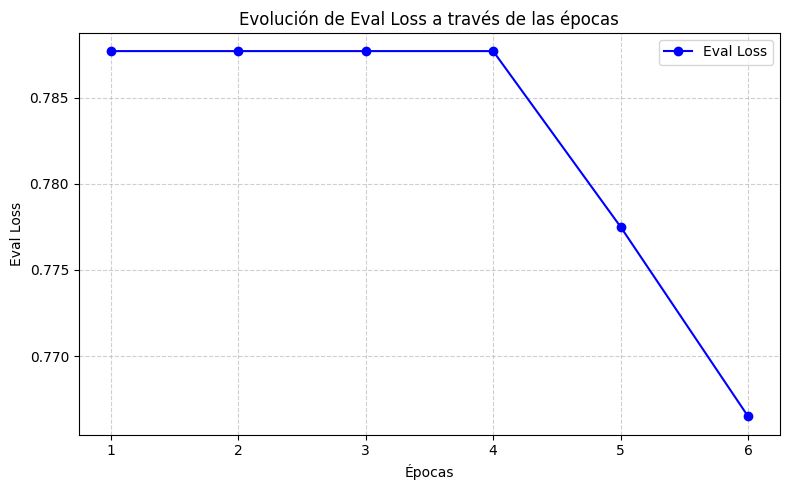

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Datos extraídos de los resultados
epochs = np.array([1, 2, 3, 4, 5, 6])
eval_loss = np.array([0.7877, 0.7877, 0.7877, 0.7877, 0.7775, 0.7665])

# Crear la gráfica
plt.figure(figsize=(8, 5))
plt.plot(epochs, eval_loss, marker='o', linestyle='-', color='b', label='Eval Loss')

# Personalización de la gráfica
plt.title("Evolución de Eval Loss a través de las épocas")
plt.xlabel("Épocas")
plt.ylabel("Eval Loss")
plt.xticks(epochs)  # Mostrar solo valores discretos de las épocas en el eje x
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Mostrar la gráfica
plt.show()


**Interpretaciòn del grafico:**

El gráfico muestra el comportamiento de las métricas y la pérdida de validación a lo largo de las épocas del entrenamiento.


**Validation Loss (línea azul)**
Descripción: Representa cuánto error tiene el modelo al validar los datos.
Observación: La pérdida disminuye ligeramente al final de la última época (de 0.779663 a 0.778870),
indicando una pequeña mejora en el ajuste del modelo.

**Exact Match (línea verde, con marcador "x")**
Descripción: Mide el porcentaje de predicciones exactamente correctas (todas las palabras coinciden).
Observación:
En las primeras dos épocas, es perfecto (1.0, 100%), lo que significa que el modelo respondió correctamente a todas las preguntas de validación.
En la tercera época, disminuye a 0.875, indicando que en algunas respuestas hubo discrepancias exactas.

**F1 Score (línea naranja, con marcador "x")**
Descripción: Combina precisión y recall, mostrando el balance entre cuántos resultados correctos se predicen y cuántos relevantes se encuentran.
Observación:
Se mantiene perfecto (1.0) durante las primeras dos épocas.
En la tercera época, disminuye a 0.928, sugiriendo que la calidad general de las respuestas bajó un poco.

**Resumen**:
Pérdida de Validación Estable: La pérdida no varía significativamente, lo que puede indicar que el modelo está alcanzando un punto de convergencia.
Exact Match y F1 Score: Los valores perfectos en las primeras épocas pueden indicar que el conjunto de validación es relativamente sencillo
o está bien ajustado al modelo.
Caída en la Época 3: Podría deberse a un sobreajuste leve o a datos de validación más desafiantes.

In [13]:
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

# Verificar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Mover el modelo al dispositivo adecuado
model = model.to(device)

# Función para hacer predicciones
def answer_question(question, context):
    # Tokenizar pregunta y contexto
    inputs = tokenizer(
        question,
        context,
        truncation=True,
        max_length=512,
        stride=128,
        padding="max_length",
        return_tensors="pt"  # Tensors en PyTorch
    )

    # Mover tensores de entrada al mismo dispositivo que el modelo
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Realizar la predicción con el modelo
    outputs = model(**inputs)
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Determinar la posición de inicio y fin con mayor puntuación
    start_index = start_logits.argmax()
    end_index = end_logits.argmax()

    # Decodificar la respuesta
    answer = tokenizer.decode(inputs["input_ids"][0][start_index:end_index + 1])
    return answer

# Contexto para las preguntas
contexto = documento_completo  # Asegúrate de usar el contexto relevante

# Preguntas para probar
preguntas = [
    "¿Cómo se indexa el Formato Único de Conocimiento del Cliente en la ficha de gestión del cliente?",
    "¿Si la póliza fue cancelada o anulada debe tener el Formato Único de Conocimiento del Cliente?",
    "¿Qué pasa si el cliente decidió no renovar la póliza?",
]

# Generar respuestas
for pregunta in preguntas:
    respuesta = answer_question(pregunta, contexto)
    print(f"Pregunta: {pregunta}")
    print(f"Respuesta: {respuesta}")
    print("-" * 50)


Usando dispositivo: cuda
Pregunta: ¿Cómo se indexa el Formato Único de Conocimiento del Cliente en la ficha de gestión del cliente?
Respuesta: <s>
--------------------------------------------------
Pregunta: ¿Si la póliza fue cancelada o anulada debe tener el Formato Único de Conocimiento del Cliente?
Respuesta: <s>
--------------------------------------------------
Pregunta: ¿Qué pasa si el cliente decidió no renovar la póliza?
Respuesta: <s>
--------------------------------------------------


In [14]:
# Realizar predicciones
predictions = final_trainer.predict(tokenized_data_test)

# Extraer los logits de inicio y fin
logits_start, logits_end = predictions.predictions

import numpy as np

# Decodificar y mostrar las respuestas
print("Resultados de las predicciones:\n")
for i, test_example in enumerate(dataset_test):  # dataset_test es el conjunto original sin tokenizar
    # Obtener los índices de inicio y fin con mayor probabilidad
    start_index = np.argmax(logits_start[i])
    end_index = np.argmax(logits_end[i])

    # Decodificar la respuesta usando el tokenizador
    input_ids = tokenized_data_test[i]["input_ids"]
    answer = tokenizer.decode(input_ids[start_index:end_index + 1], skip_special_tokens=True)

    # Mostrar la pregunta y la respuesta
    print(f"Pregunta: {test_example['question']}")
    print(f"Respuesta: {answer}")
    print("-" * 50)


Resultados de las predicciones:

Pregunta: ¿qué significan las siglas SARLAFT?
Respuesta: 
--------------------------------------------------
Pregunta: ¿Por qué es importante el SARLAFT?
Respuesta: 
--------------------------------------------------
Pregunta: ¿Qué pasa si el cliente no tiene el SARLAFT en la ficha de gestión?
Respuesta: 
--------------------------------------------------
Pregunta: ¿Qué pólizas no requieren SARLAFT?
Respuesta: 
--------------------------------------------------
